In [1]:
!pip install openai

!pip install transformers
!pip install tokenizers





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 10.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [2]:
#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from google.colab import drive
import random
#gpt2
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

#pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Your code here # read data
trump_tweets=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/realdonaldtrump.csv")
trump_tweets.head()

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [36]:
#tweets_fil =trump_tweets[trump_tweets['isRetweet']=='f']
#del trump_tweets

tweets = trump_tweets['content'].copy()
#tweets =tweets[:30000]
tweets.head()
print(tweets)

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
43347    Joe Biden was a TOTAL FAILURE in Government. H...
43348    Will be interviewed on @ seanhannity tonight a...
43349                           pic.twitter.com/3lm1spbU8X
43350                           pic.twitter.com/vpCE5MadUz
43351                           pic.twitter.com/VLlc0BHW41
Name: content, Length: 43352, dtype: object


In [37]:

# Load the Trump tweet corpus
#trump_tweets = pd.read_csv('trump_tweets.csv', encoding='utf-8')

# Preprocess the tweets by removing URLs, mentions, and hashtags
def preprocess_tweet_text(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove mentions
    tweet = re.sub(r"@\S+", "", tweet)
    # Remove hashtags
    tweet = re.sub(r"#\S+", "", tweet)
    # Remove newline characters
    tweet = tweet.replace('\n', ' ')
    # Remove extra spaces
    tweet = re.sub(r"\s+", ' ', tweet)
    return tweet.strip()


#Section 1.2 Cleaning the data:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+|pic.twitter.com/\S+', '', text)

def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    
def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
     pattern = r'([.,!?-])'
     s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
     s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
     return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def make_lower(text):
  return text.lower()

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", no_link)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)

    no_punct = rm_punct2(clean_tweet)

    no_html = rm_html(no_punct)
    no_extra= preprocess_tweet_text(no_html)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(no_extra)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    lower = make_lower(no_emoji)
    spell_corrected = spell_correction(lower)
    
    return spell_corrected

  
print(tweets)
tweets = tweets.apply(clean_pipeline)
tweets=tweets.replace('', np.nan).dropna()
tweets.head()
print(tweets)
tweets.size

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
43347    Joe Biden was a TOTAL FAILURE in Government. H...
43348    Will be interviewed on @ seanhannity tonight a...
43349                           pic.twitter.com/3lm1spbU8X
43350                           pic.twitter.com/vpCE5MadUz
43351                           pic.twitter.com/VLlc0BHW41
Name: content, Length: 43352, dtype: object
0        be sure to tune in and watch donald trump on l...
1        donald trump will be appearing on the view tom...
2        donald trump reads top ten financial tips on l...
3        new blog post celebrity apprentice finale and ...
4        my persona will never be that of a wallflower ...
            

42814

In [9]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

Here I added three new tokens in the pre-trained GPT2 tokenizer: \ <|sos|> : start of sentence \ <|eos|> : end of sentence \ <|pad|> : padding token



In [39]:
max_tweet = min(max([len(tokenizer.encode(tweet)) for tweet in tweets]),100)

print(f'The longest tweet is {max_tweet} tokens long.')

The longest tweet is 68 tokens long.


Next we create a custom dataloader for our tweets using torch Dataset. \ Each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask



In [40]:
batch_size = 32

class TweetDataset(Dataset):
    def __init__(self,tweets,tokenizer,gpt2_type="gpt2",max_length=max_tweet):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for tweet in tweets:
            encoding_dict = tokenizer('<|sos|>'+ tweet +'<|eos|>',truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
            
            self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention_masks[idx]

In [41]:
#90% training 10% validation

dataset = TweetDataset(tweets,tokenizer,max_length=max_tweet)
train_size = int(0.90 * len(dataset))
val_size = len(dataset)-train_size

train,val = random_split(dataset,[train_size,val_size])
print(f'Number of train samples = {train_size} and Number of validation samples = {val_size}')

Number of train samples = 38532 and Number of validation samples = 4282


In [42]:
import torch
import torch.nn as nn

configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
# Define dropout probability
dropout_prob = 0.081

# Add dropout to each layer of the model
for layer in model.transformer.h:
    layer.dropout = nn.Dropout(dropout_prob)
    
model.resize_token_embeddings(len(tokenizer))
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [43]:
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs =10
warmup_steps = 1e2
sample_every = 100

In [44]:
train_dataloader = DataLoader(train,sampler = RandomSampler(train),
                             batch_size = batch_size)

val_dataloader = DataLoader(val,sampler = SequentialSampler(val),
                           batch_size = batch_size)

In [45]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.1)



In [46]:

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
         

In [48]:

import gc
gc.collect()
torch.cuda.empty_cache()


In [49]:
!nvidia-smi


Sat Mar 11 15:16:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |   4473MiB / 15360MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
import time
import datetime
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        
        
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 10
Batch 100 of 1205. Loss:2.719233751296997. Time:0:01:02
Example output:  bipartisan or unqualified, in order that a person or entity not otherwise qualified to be an
Batch 200 of 1205. Loss:2.2484054565429688. Time:0:02:06
Example output:  increasing its
Batch 300 of 1205. Loss:1.9724446535110474. Time:0:03:10
Example output: day a morning dream daydreaming that he won't be forgotten
Batch 400 of 1205. Loss:1.9877684116363525. Time:0:04:11
Example output:  Hangen_johntrump was just a good man to me at that time he should resign in disgrace and in contempt of humanity he lied and did not commit suicide he will be ashamed to be impeached
Batch 500 of 1205. Loss:1.9718440771102905. Time:0:05:15
Example output:  foodsf a week of hardworking people in this country will be harder on our allies than we believe them to be in our country for what they are worth and for what they can do if they are able to get out our votes we will be able to keep our jobs and our freedom

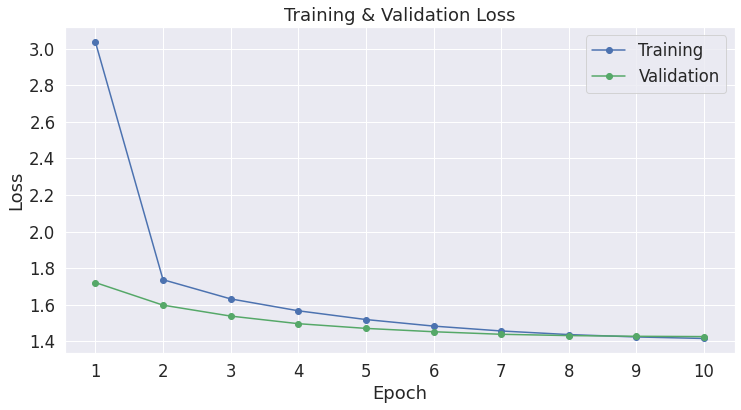

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 10)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

In [52]:
import os
out_dir = '/content/drive/MyDrive/Colab Notebooks/'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)



('/content/drive/MyDrive/Colab Notebooks/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/added_tokens.json')

In [53]:

model.eval()

prompt = "<|sos|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: alexsalmond s wife  has been a huge star in the political arena but doesnt have a lot to offer for the good of the nation i dont agree with her


1: my foxandfriends interview discussing the new apprentice 


2: i am excited to bring you trump iowa tomorrow thursday at pme from pme 


3: our national debt will have reached a record high to begin with as our troops continue to push back against the radical left we must get the american people the help we need  nancy pelosi to tell it like it is will make america great again


4: the fbi and other agencies of the federal government have not been given a complete and total review of these witch hunt attacks and the many thousands of pages that must be destroyed the way the democrats have been treated and the entire mess is going nowhere and is no longer worthy of our attention




In [54]:
#Load Saved Model

model = GPT2LMHeadModel.from_pretrained('./')
tokenizer = GPT2Tokenizer.from_pretrained('./')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [55]:
tweet_2012 = 'this is crazy  '
model.eval()

prompt = tweet_2012

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 250,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, outputs in enumerate(outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(outputs, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: this is crazy  


1: this is crazy  


2: this is crazy  


3: this is crazy  


4: this is crazy  




In [56]:
# save the model to disk
import pickle
filename = '/content/drive/MyDrive/Colab Notebooks/finalized_model10E_improved_pp.sav'
pickle.dump(model, open(filename, 'wb'))

In [57]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro